In [3]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

/home/ddsm/Installation/anaconda3/envs/Deeplsd/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [4]:
# Load an image
img = cv2.imread('../assets/images/input_0001.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'sharpen': True,  # Use the DF normalization (should be True)
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'optimize': False,  # Whether to refine the lines after detecting them
        'use_vps': True,  # Whether to use vanishing points (VPs) in the refinement
        'optimize_vps': True,  # Whether to also refine the VPs in the refinement
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()


/tmp/ipykernel_5422/139355880.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(ckpt), map_location='cpu')


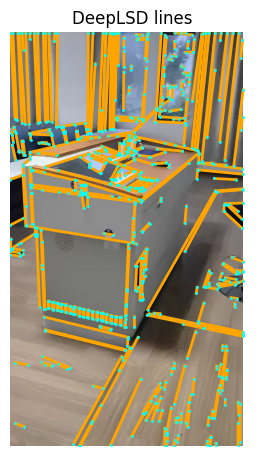

In [5]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))